## INTRODUCCIÓN

Los clientes de Beta Bank estan desertando mes a mes, en este proceso los banqueros llegaron a la conclusion que es mas barato retener clientes que captar nuevos, por lo que la retención de clientes es crucial para mantener una base sólida y garantizar el crecimiento sostenible de la compañía. 

### Objetivos del Proyecto


- Desarrollar un modelo de clasificación con la mayor precisión posible para predecir la deserción de clientes, este modelo ayudará al banco a identificar a los clientes en riesgo de abandonar y permitirá la implementación de estrategias de retención personalizadas.

### Estructura del Proyecto


- Carga e Importación de Datos: Importaremos y exploraremos los datos disponibles para comprender su estructura.
- Análisis Exploratorio de Datos: Realizaremos un análisis detallado de los datos en busca de alguna posible anomalía.
- segmentación de datos: Dividiremos los datos en conjunto de entrenamiento, validación y prueba.
- Desarrollo y evaluación de los modelos: Desarrollaremos modelos y elegiremos el mejor basándonos en nuestro objetivo.
- Conclusiones: Finalmente, daremos las conclusiones basándonos en lo que se encontró en el proyecto.

## Preparación y Carga de Datos

Primero, vamos a cargar los datos y preparar el conjunto de datos para el análisis.

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [28]:
# Cargar los datos
data = pd.read_csv('datasets/Churn.csv')

In [29]:
# Mostrar las primeras filas del conjunto de datos
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Exploración de los Datos

In [30]:
print(data.info())

print()

print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  1000

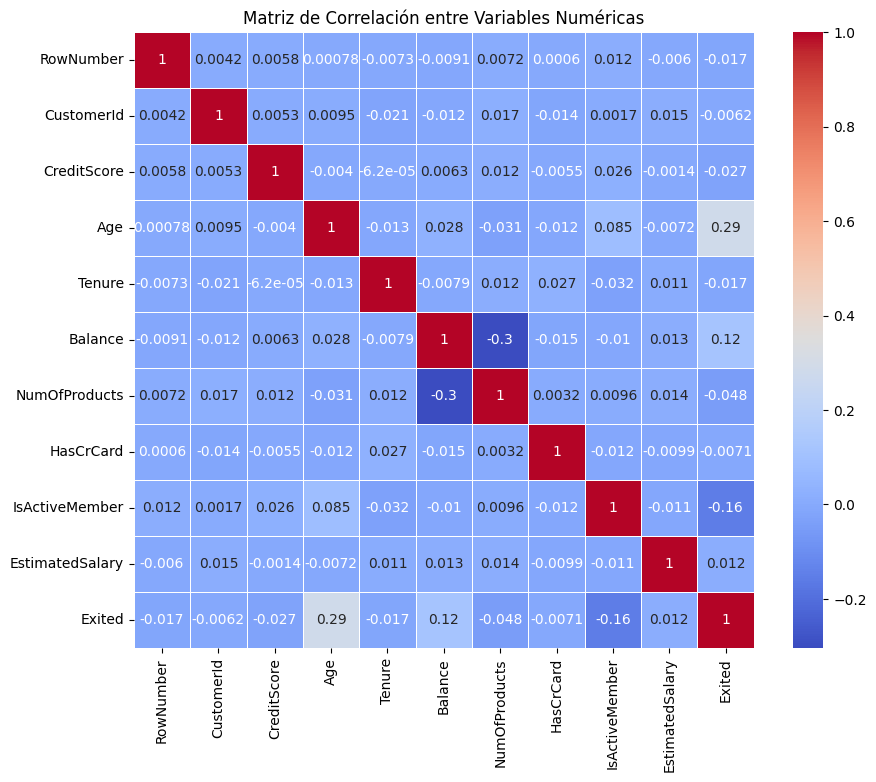

In [41]:
# Filtrar solo columnas numéricas
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
corr_matrix = numeric_data.corr()

# Visualizar el heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()


Dado que la correlación entre las variables numéricas y la deserción es relativamente baja, es muy probable que un modelo lineal como la regresión logística no capture completamente la complejidad de los datos.

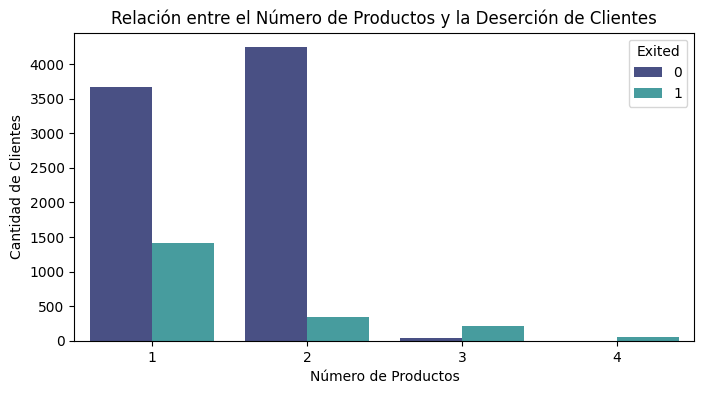

In [40]:
plt.figure(figsize=(8, 4))
sns.countplot(x='NumOfProducts', hue='Exited', data=data, palette='mako')
plt.title('Relación entre el Número de Productos y la Deserción de Clientes')
plt.xlabel('Número de Productos')
plt.ylabel('Cantidad de Clientes')
plt.show()


Aunque el número de clientes con 3 o 4 productos es bajo, la proporción de deserción en este grupo parece alta.
Podría ser necesario ofrecer productos o servicios más personalizados, mejorar la comunicación o brindar una atención al cliente más dedicada.

## Limpieza y Preprocesamiento de Datos

###  Imputación de Valores Nulos

Observamos que la columna Tenure tiene valores nulos. Vamos a reemplazar esos valores nulos con la mediana de la columna. La mediana es el valor que separa la mitad superior de la mitad inferior de los datos, y es menos sensible a valores extremos comparado con la media.

In [5]:
# Imputar valores nulos en la columna 'Tenure' con la mediana
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

print(data.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


C:\Users\juan6\AppData\Local\Temp\ipykernel_20296\505321135.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Tenure'].fillna(data['Tenure'].median(), inplace=True)


### Eliminar columnas irrelevantes

In [6]:
# Eliminar columnas irrelevantes
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Eliminamos columnas que no aportan valor significativo al modelo (RowNumber, CustomerId, Surname)

## Preprocesamiento de Datos

### Regresión Logística (One-Hot Encoding)
Convertimos variables categóricas usando One-Hot Encoding:

In [7]:
# Convertir variables categóricas usando One-Hot Encoding
data_ohe = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)

# Separar características y objetivo para Regresión Logística
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)

# Dividir los datos en conjuntos de entrenamiento y validación
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

# Características numéricas a estandarizar
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Crear y ajustar el escalador
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None

# Transformar las características numéricas en los conjuntos de entrenamiento y validación
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


Para modelos de regresión es mejor usar One-Hot para convertir las variables categóricas en numéricas. 

### Modelos Basados en Árboles (Label Encoding)

In [8]:
# Codificación de etiquetas para árboles de decisión y bosques aleatorios
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

# Separar características y objetivo
target_tree = data_ordinal['Exited']
features_tree = data_ordinal.drop(['Exited'], axis=1)

# División de los datos en conjuntos de entrenamiento y validación
features_tree_train, features_tree_valid, target_tree_train, target_tree_valid = train_test_split(
    features_tree, target_tree, test_size=0.25, random_state=12345)

Para bosque aleatorio y árbol de decisión es mejor usar codificación de etiquetas para convertir variables categóricas en numéricas.

## Manejo del Desequilibrio de Clases

In [9]:
# Verificar la distribución de la variable objetivo
print(data['Exited'].value_counts(normalize=True))

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Como podemos ver, hay desequilibrio de clases, por lo que usaremos métodos para corregir este desequilibrio.

### Funciones de Sobremuestreo y Submuestreo


In [10]:
# Función de sobremuestreo
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

# Función de submuestreo
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

## Modelos y Evaluación

### Regresión Logística Sin Balanceo

Entrenamos un modelo de regresión logística sin tener en cuenta el desequilibrio de clases y evaluamos su rendimiento:

In [11]:
# Entrenar un modelo de regresión logística
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)

# Realizar predicciones
predicted_valid_lr = model_lr.predict(features_valid)
probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_lr = f1_score(target_valid, predicted_valid_lr)
auc_roc_lr = roc_auc_score(target_valid, probabilities_valid_lr)

print("Regresión Logística - F1 inicial:", f1_lr)
print("Regresión Logística - AUC-ROC inicial:", auc_roc_lr)


Regresión Logística - F1 inicial: 0.2948539638386648
Regresión Logística - AUC-ROC inicial: 0.7585579415471689


Como podemos ver, el valor de F1 no cumple con lo que buscamos. 

### Regresión Logística con Sobremuestreo

In [12]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

# Entrenar el modelo con sobremuestreo
model_lr_upsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_upsampled.fit(features_upsampled, target_upsampled)

# Realizar predicciones
predicted_valid_lr_upsampled = model_lr_upsampled.predict(features_valid)
probabilities_valid_lr_upsampled = model_lr_upsampled.predict_proba(features_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_lr_upsampled = f1_score(target_valid, predicted_valid_lr_upsampled)
auc_roc_lr_upsampled = roc_auc_score(target_valid, probabilities_valid_lr_upsampled)

print("Regresión Logística - F1 con sobremuestreo:", f1_lr_upsampled)
print("Regresión Logística - AUC-ROC con sobremuestreo:", auc_roc_lr_upsampled)


Regresión Logística - F1 con sobremuestreo: 0.4299474605954466
Regresión Logística - AUC-ROC con sobremuestreo: 0.7652079617607191


La regresión con sobremuestreo  mejora el modelo, pero no llegamos a lo que buscamos con F1.

### Regresión Logística con Submuestreo


In [13]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

# Entrenar el modelo con submuestreo
model_lr_downsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_downsampled.fit(features_downsampled, target_downsampled)

# Realizar predicciones
predicted_valid_lr_downsampled = model_lr_downsampled.predict(features_valid)
probabilities_valid_lr_downsampled = model_lr_downsampled.predict_proba(features_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_lr_downsampled = f1_score(target_valid, predicted_valid_lr_downsampled)
auc_roc_lr_downsampled = roc_auc_score(target_valid, probabilities_valid_lr_downsampled)

print("Regresión Logística - F1 con submuestreo:", f1_lr_downsampled)
print("Regresión Logística - AUC-ROC con submuestreo:", auc_roc_lr_downsampled)


Regresión Logística - F1 con submuestreo: 0.4293935369632581
Regresión Logística - AUC-ROC con submuestreo: 0.7671180233525956


La regresión con submuestreo tampoco llega a lo que buscamos con F1.

### Regresión Logística con Ajuste de Pesos de Clase

In [14]:
# Entrenar un modelo de regresión logística con ajuste de pesos de clase
model_lr_class_weight = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model_lr_class_weight.fit(features_train, target_train)

# Realizar predicciones
predicted_valid_lr_class_weight = model_lr_class_weight.predict(features_valid)
probabilities_valid_lr_class_weight = model_lr_class_weight.predict_proba(features_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_lr_class_weight = f1_score(target_valid, predicted_valid_lr_class_weight)
auc_roc_lr_class_weight = roc_auc_score(target_valid, probabilities_valid_lr_class_weight)

print("Regresión Logística - F1 con ajuste de pesos de clase:", f1_lr_class_weight)
print("Regresión Logística - AUC-ROC con ajuste de pesos de clase:", auc_roc_lr_class_weight)


Regresión Logística - F1 con ajuste de pesos de clase: 0.5050234427327528
Regresión Logística - AUC-ROC con ajuste de pesos de clase: 0.7632522413260088


La regresión con el ajuste de pesos de clase mejora, pero no llega a lo que buscamos.

### Ajuste de Umbral para Regresión Logística

In [15]:
# Ajuste de Umbral
probabilities_valid_lr_umbral = model_lr.predict_proba(features_valid)[:, 1]
for threshold in np.arange(0, 0.92, 0.02):
    predicted_valid_lr_umbral = probabilities_valid_lr_umbral > threshold
    precision_lr_umbral = precision_score(target_valid, predicted_valid_lr_umbral)
    recall_lr_umbral = recall_score(target_valid, predicted_valid_lr_umbral)
    f1_lr_umbral = f1_score(target_valid, predicted_valid_lr_umbral)
    auc_roc_lr_umbral = roc_auc_score(target_tree_valid, predicted_valid_lr_umbral)
    print(f'Threshold = {threshold:.2f} | Precision = {precision_lr_umbral:.3f}, Recall = {recall_lr_umbral:.3f}, F1 = {f1_lr_umbral:.3f}, AUC-ROC = {auc_roc_lr_umbral:.3f}')

Threshold = 0.00 | Precision = 0.214, Recall = 1.000, F1 = 0.353, AUC-ROC = 0.500
Threshold = 0.02 | Precision = 0.215, Recall = 1.000, F1 = 0.355, AUC-ROC = 0.504
Threshold = 0.04 | Precision = 0.225, Recall = 0.981, F1 = 0.366, AUC-ROC = 0.531
Threshold = 0.06 | Precision = 0.243, Recall = 0.953, F1 = 0.387, AUC-ROC = 0.573
Threshold = 0.08 | Precision = 0.263, Recall = 0.933, F1 = 0.411, AUC-ROC = 0.611
Threshold = 0.10 | Precision = 0.283, Recall = 0.895, F1 = 0.430, AUC-ROC = 0.639
Threshold = 0.12 | Precision = 0.304, Recall = 0.852, F1 = 0.448, AUC-ROC = 0.661
Threshold = 0.14 | Precision = 0.328, Recall = 0.821, F1 = 0.468, AUC-ROC = 0.681
Threshold = 0.16 | Precision = 0.347, Recall = 0.781, F1 = 0.480, AUC-ROC = 0.690
Threshold = 0.18 | Precision = 0.367, Recall = 0.750, F1 = 0.493, AUC-ROC = 0.699
Threshold = 0.20 | Precision = 0.387, Recall = 0.707, F1 = 0.500, AUC-ROC = 0.701
Threshold = 0.22 | Precision = 0.407, Recall = 0.667, F1 = 0.505, AUC-ROC = 0.701
Threshold = 0.24

Con el ajuste de umbral a 0.26 se mejora, pero aún no se llega a lo que buscamos.

Con modelos de regresión no llegaremos a lo que buscamos. 

### Árbol de Decisión Sin Balanceo

In [16]:
# Entrenar un modelo de árbol de decisión
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_tree_train, target_tree_train)

# Realizar predicciones
predicted_valid_tree = model_tree.predict(features_tree_valid)
probabilities_valid_tree = model_tree.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_tree = f1_score(target_tree_valid, predicted_valid_tree)
auc_roc_tree = roc_auc_score(target_tree_valid, probabilities_valid_tree)

print("Árbol de Decisión - F1 inicial:", f1_tree)
print("Árbol de Decisión - AUC-ROC inicial:", auc_roc_tree)


Árbol de Decisión - F1 inicial: 0.46225535880708296
Árbol de Decisión - AUC-ROC inicial: 0.6579843523340706


### Árbol de Decisión con Sobremuestreo

In [17]:
features_tree_upsampled, target_tree_upsampled = upsample(features_tree_train, target_tree_train, 10)

# Entrenar el modelo con sobremuestreo
model_tree_upsampled = DecisionTreeClassifier(random_state=12345)
model_tree_upsampled.fit(features_tree_upsampled, target_tree_upsampled)

# Realizar predicciones
predicted_valid_tree_upsampled = model_tree_upsampled.predict(features_tree_valid)
probabilities_valid_tree_upsampled = model_tree_upsampled.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_tree_upsampled = f1_score(target_tree_valid, predicted_valid_tree_upsampled)
auc_roc_tree_upsampled = roc_auc_score(target_tree_valid, probabilities_valid_tree_upsampled)

print("Árbol de Decisión - F1 con sobremuestreo:", f1_tree_upsampled)
print("Árbol de Decisión - AUC-ROC con sobremuestreo:", auc_roc_tree_upsampled)


Árbol de Decisión - F1 con sobremuestreo: 0.4970178926441352
Árbol de Decisión - AUC-ROC con sobremuestreo: 0.6774107631209721


En el caso del árbol de decisión con el sobremuestreo se mejoran los valores de F1 y AUC-ROC, pero aún no llegamos a lo que necesitamos. 

### Árbol de Decisión con Submuestreo

In [18]:
features_tree_downsampled, target_tree_downsampled = downsample(features_tree_train, target_tree_train, 0.1)

# Entrenar el modelo con submuestreo
model_tree_downsampled = DecisionTreeClassifier(random_state=12345)
model_tree_downsampled.fit(features_tree_downsampled, target_tree_downsampled)

# Realizar predicciones
predicted_valid_tree_downsampled = model_tree_downsampled.predict(features_tree_valid)
probabilities_valid_tree_downsampled = model_tree_downsampled.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_tree_downsampled = f1_score(target_tree_valid, predicted_valid_tree_downsampled)
auc_roc_tree_downsampled = roc_auc_score(target_tree_valid, probabilities_valid_tree_downsampled)

print("Árbol de Decisión - F1 con submuestreo:", f1_tree_downsampled)
print("Árbol de Decisión - AUC-ROC con submuestreo:", auc_roc_tree_downsampled)


Árbol de Decisión - F1 con submuestreo: 0.4776280323450135
Árbol de Decisión - AUC-ROC con submuestreo: 0.6908634753037979


En el caso del árbol de decisión con el submuestreo se mejora los valores de F1 y AUC-ROC, pero aún no llegamos a lo que necesitamos. 

### Árbol de Decisión con Ajuste de Pesos de Clase

In [19]:
# Entrenar un modelo de árbol de decisión con ajuste de pesos de clase
model_tree_class_weight = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_class_weight.fit(features_tree_train, target_tree_train)

# Realizar predicciones
predicted_valid_tree_class_weight = model_tree_class_weight.predict(features_tree_valid)
probabilities_valid_tree_class_weight = model_tree_class_weight.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_tree_class_weight = f1_score(target_tree_valid, predicted_valid_tree_class_weight)
auc_roc_tree_class_weight = roc_auc_score(target_tree_valid, probabilities_valid_tree_class_weight)

print("Árbol de Decisión - F1 con ajuste de pesos de clase:", f1_tree_class_weight)
print("Árbol de Decisión - AUC-ROC con ajuste de pesos de clase:", auc_roc_tree_class_weight)


Árbol de Decisión - F1 con ajuste de pesos de clase: 0.4814462416745956
Árbol de Decisión - AUC-ROC con ajuste de pesos de clase: 0.6695274785379657


Aún no llegamos a los valores deseados. 

### Ajuste de Umbral para Árbol de Decisión

In [20]:
# Entrenar un modelo de árbol de decisión
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_tree.fit(features_tree_train, target_tree_train)
# Obtener las probabilidades predichas para la clase positiva
probabilities_valid_tree_umbral = model_tree.predict_proba(features_tree_valid)[:, 1]
for threshold in np.arange(0, 0.92, 0.02):
    predicted_valid_tree_umbral = probabilities_valid_tree_umbral > threshold
    precision = precision_score(target_tree_valid, predicted_valid_tree_umbral)
    recall = recall_score(target_tree_valid, predicted_valid_tree_umbral)
    f1 = f1_score(target_tree_valid, predicted_valid_tree_umbral)
    auc_roc = roc_auc_score(target_tree_valid, predicted_valid_tree_umbral)
    
    print(f'Threshold = {threshold:.2f} | Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}, AUC-ROC = {auc_roc:.3f}')

Threshold = 0.00 | Precision = 0.212, Recall = 0.983, F1 = 0.348, AUC-ROC = 0.493
Threshold = 0.02 | Precision = 0.253, Recall = 0.959, F1 = 0.400, AUC-ROC = 0.593
Threshold = 0.04 | Precision = 0.263, Recall = 0.953, F1 = 0.413, AUC-ROC = 0.614
Threshold = 0.06 | Precision = 0.302, Recall = 0.927, F1 = 0.456, AUC-ROC = 0.672
Threshold = 0.08 | Precision = 0.347, Recall = 0.858, F1 = 0.495, AUC-ROC = 0.710
Threshold = 0.10 | Precision = 0.355, Recall = 0.849, F1 = 0.500, AUC-ROC = 0.714
Threshold = 0.12 | Precision = 0.388, Recall = 0.826, F1 = 0.528, AUC-ROC = 0.736
Threshold = 0.14 | Precision = 0.440, Recall = 0.798, F1 = 0.567, AUC-ROC = 0.761
Threshold = 0.16 | Precision = 0.443, Recall = 0.770, F1 = 0.562, AUC-ROC = 0.753
Threshold = 0.18 | Precision = 0.460, Recall = 0.759, F1 = 0.573, AUC-ROC = 0.758
Threshold = 0.20 | Precision = 0.480, Recall = 0.723, F1 = 0.577, AUC-ROC = 0.755
Threshold = 0.22 | Precision = 0.484, Recall = 0.723, F1 = 0.580, AUC-ROC = 0.757
Threshold = 0.24

Aquí usamos hiperparámetros(max_depth) para mejorar el modelo, finalmente llegamos al valor deseado de F1 = 0.595, con un umbral de 0.24 

### Bosque Aleatorio Sin Balanceo

In [21]:
# Entrenar un modelo de bosque aleatorio
model_rf = RandomForestClassifier(random_state=12345)
model_rf.fit(features_tree_train, target_tree_train)

# Realizar predicciones
predicted_valid_rf = model_rf.predict(features_tree_valid)
probabilities_valid_rf = model_rf.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_rf = f1_score(target_tree_valid, predicted_valid_rf)
auc_roc_rf = roc_auc_score(target_tree_valid, probabilities_valid_rf)

print("Bosque Aleatorio - F1 inicial:", f1_rf)
print("Bosque Aleatorio - AUC-ROC inicial:", auc_roc_rf)


Bosque Aleatorio - F1 inicial: 0.5659928656361475
Bosque Aleatorio - AUC-ROC inicial: 0.8519535801764524


Para bosque aleatorio, el valor inicial sin balanceo aún está por debajo. 

### Bosque Aleatorio con Sobremuestreo

In [22]:
features_tree_upsampled, target_tree_upsampled = upsample(features_tree_train, target_tree_train, 10)

# Entrenar el modelo con sobremuestreo
model_rf_upsampled = RandomForestClassifier(random_state=12345)
model_rf_upsampled.fit(features_tree_upsampled, target_tree_upsampled)

# Realizar predicciones
predicted_valid_rf_upsampled = model_rf_upsampled.predict(features_tree_valid)
probabilities_valid_rf_upsampled = model_rf_upsampled.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_rf_upsampled = f1_score(target_tree_valid, predicted_valid_rf_upsampled)
auc_roc_rf_upsampled = roc_auc_score(target_tree_valid, probabilities_valid_rf_upsampled)

print("Bosque Aleatorio - F1 con sobremuestreo:", f1_rf_upsampled)
print("Bosque Aleatorio - AUC-ROC con sobremuestreo:", auc_roc_rf_upsampled)


Bosque Aleatorio - F1 con sobremuestreo: 0.5962343096234309
Bosque Aleatorio - AUC-ROC con sobremuestreo: 0.8438653064136405


Con el sobremuestreo para bosque aleatorio llegamos al valor deseado con F1 = 0.596 

### Bosque Aleatorio con Submuestreo

In [23]:
features_tree_downsampled, target_tree_downsampled = downsample(features_tree_train, target_tree_train, 0.1)

# Entrenar el modelo con submuestreo
model_rf_downsampled = RandomForestClassifier(random_state=12345)
model_rf_downsampled.fit(features_tree_downsampled, target_tree_downsampled)

# Realizar predicciones
predicted_valid_rf_downsampled = model_rf_downsampled.predict(features_tree_valid)
probabilities_valid_rf_downsampled = model_rf_downsampled.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_rf_downsampled = f1_score(target_tree_valid, predicted_valid_rf_downsampled)
auc_roc_rf_downsampled = roc_auc_score(target_tree_valid, probabilities_valid_rf_downsampled)

print("Bosque Aleatorio - F1 con submuestreo:", f1_rf_downsampled)
print("Bosque Aleatorio - AUC-ROC con submuestreo:", auc_roc_rf_downsampled)


Bosque Aleatorio - F1 con submuestreo: 0.4989816700610998
Bosque Aleatorio - AUC-ROC con submuestreo: 0.8477158688259494


Con el submuestreo los valores se mantienen por debajo de 0.59 para F1. 

### Bosque Aleatorio con Ajuste de Pesos de Clase

In [24]:
# Entrenar un modelo de bosque aleatorio con ajuste de pesos de clase
model_rf_class_weight = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_rf_class_weight.fit(features_tree_train, target_tree_train)

# Realizar predicciones
predicted_valid_rf_class_weight = model_rf_class_weight.predict(features_tree_valid)
probabilities_valid_rf_class_weight = model_rf_class_weight.predict_proba(features_tree_valid)[:, 1]

# Calcular F1 y AUC-ROC
f1_rf_class_weight = f1_score(target_tree_valid, predicted_valid_rf_class_weight)
auc_roc_rf_class_weight = roc_auc_score(target_tree_valid, probabilities_valid_rf_class_weight)

print("Bosque Aleatorio - F1 con ajuste de pesos de clase:", f1_rf_class_weight)
print("Bosque Aleatorio - AUC-ROC con ajuste de pesos de clase:", auc_roc_rf_class_weight)


Bosque Aleatorio - F1 con ajuste de pesos de clase: 0.5531400966183575
Bosque Aleatorio - AUC-ROC con ajuste de pesos de clase: 0.853254857197213


Con el ajuste de peso tampoco se llega a lo que se busca en F1.

### Ajuste de Umbral para Bosque Aleatorio

In [25]:
probabilities_valid_rf = model_rf.predict_proba(features_tree_valid)[:, 1]
for threshold in np.arange(0, 0.92, 0.02):
    predicted_valid_rf = probabilities_valid_rf > threshold
    precision = precision_score(target_tree_valid, predicted_valid_rf)
    recall = recall_score(target_tree_valid, predicted_valid_rf)
    f1 = f1_score(target_tree_valid, predicted_valid_rf)
    auc_roc = roc_auc_score(target_tree_valid, predicted_valid_rf)
    print(f'Threshold = {threshold:.2f} | Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}, AUC-ROC = {auc_roc:.3f}')


Threshold = 0.00 | Precision = 0.227, Recall = 0.993, F1 = 0.369, AUC-ROC = 0.536
Threshold = 0.02 | Precision = 0.253, Recall = 0.972, F1 = 0.401, AUC-ROC = 0.595
Threshold = 0.04 | Precision = 0.282, Recall = 0.961, F1 = 0.436, AUC-ROC = 0.648
Threshold = 0.06 | Precision = 0.304, Recall = 0.942, F1 = 0.459, AUC-ROC = 0.677
Threshold = 0.08 | Precision = 0.331, Recall = 0.921, F1 = 0.487, AUC-ROC = 0.707
Threshold = 0.10 | Precision = 0.355, Recall = 0.897, F1 = 0.509, AUC-ROC = 0.727
Threshold = 0.12 | Precision = 0.383, Recall = 0.877, F1 = 0.533, AUC-ROC = 0.746
Threshold = 0.14 | Precision = 0.408, Recall = 0.847, F1 = 0.550, AUC-ROC = 0.756
Threshold = 0.16 | Precision = 0.426, Recall = 0.824, F1 = 0.562, AUC-ROC = 0.761
Threshold = 0.18 | Precision = 0.449, Recall = 0.806, F1 = 0.577, AUC-ROC = 0.768
Threshold = 0.20 | Precision = 0.482, Recall = 0.787, F1 = 0.598, AUC-ROC = 0.778
Threshold = 0.22 | Precision = 0.498, Recall = 0.764, F1 = 0.603, AUC-ROC = 0.777
Threshold = 0.24

Aquí en el ajuste de umbral igual a 0.40 tenemos un valor de F1 igual a 0.616, por lo que esté sería el mejor valor. 

## Modelo elegido Bosque aleatorio con ajuste de umbral a 0.4

In [26]:
# Realizar predicciones
predicted_valid_eleg = model_rf.predict(features_tree_valid)
probabilities_valid_eleg = model_rf.predict_proba(features_tree_valid)[:, 1]



predicted_valid_eleg = probabilities_valid_eleg > 0.40
precision = precision_score(target_tree_valid, predicted_valid_eleg)
recall = recall_score(target_tree_valid, predicted_valid_eleg)
f1 = f1_score(target_tree_valid, predicted_valid_eleg)
auc_roc = roc_auc_score(target_tree_valid, predicted_valid_eleg)
print(f'Threshold = {threshold:.2f} | Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}, AUC-ROC = {auc_roc:.3f}')


Threshold = 0.90 | Precision = 0.697, Recall = 0.551, F1 = 0.616, AUC-ROC = 0.743


## Conclusiones

- En este proyecto, cargamos y trabajamos con el dataset Churn.csv, que contiene información sobre clientes de una compañía bancaria Beta Bank.
- Imputamos valores faltantes en la columna Tenure utilizando la mediana y eliminamos columnas irrelevantes para el análisis (RowNumber, CustomerId, Surname).
- Exploramos las características del dataset y verificamos la distribución de la variable objetivo Exited.
- Utilizamos One-Hot Encoding para las variables categóricas (Geography y Gender) para modelos de regresión y codificación de etiquetas para árbol de decisión y bosque aleatorio.
- Aplicamos StandardScaler para estandarizar las características numéricas.
- Preparamos modelos basándonos en árbol de decisión, bosque aleatorio y regresión logística.
- Aplicamos técnicas para combatir el desequilibrio de clases, técnicas como submuestreo, sobremuestreo y ajuste de pesos.
- Ajustamos el umbral para obtener mejores valores de F1 y AUC-ROC.
- El mejor modelo fue el Bosque Aleatorio con un umbral ajustado a 0.40 como el modelo óptimo.
-  El modelo final puede predecir de manera efectiva la probabilidad de que un cliente abandone el banco, lo que puede ayudar a la compañía a tomar medidas preventivas para retener clientes y mejorar la satisfacción del cliente.
- Este proyecto proporcionó un modelo robusto y preciso para predecir el comportamiento de clientes, lo que puede tener un impacto significativo en las estrategias de retención de clientes y la optimización de ingresos de la compañía bancaria.